# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess, workers = 30)

Loading ychr



In [2]:
gt <- read_vcf(here("data/vcf/full_modern.vcf.gz"), mindp = 3, maxdp = 0.98) %>% select(-ustishim)

In [3]:
samples <- read_info(gt)

In [4]:
branch_lengths <- 
    crossing(
        a = filter(samples, pop == "Africa")$name,
        b = filter(samples, pop != "Africa", pop != "EMH")$name
    ) %>%
    pmap_dfr(function(a, b) {
        x <- gt[, c("chimp", a, b)] %>% filter(complete.cases(.))

        tibble(
            afr = a,
            nonafr = b,
            nonafr_der = sum(x[["chimp"]] == x[[a]] & x[["chimp"]] != x[[b]]),
            afr_der = sum(x[["chimp"]] == x[[b]] & x[["chimp"]] != x[[a]]),
            ratio = afr_der / nonafr_der,
            total = nrow(x)
        )    
    })

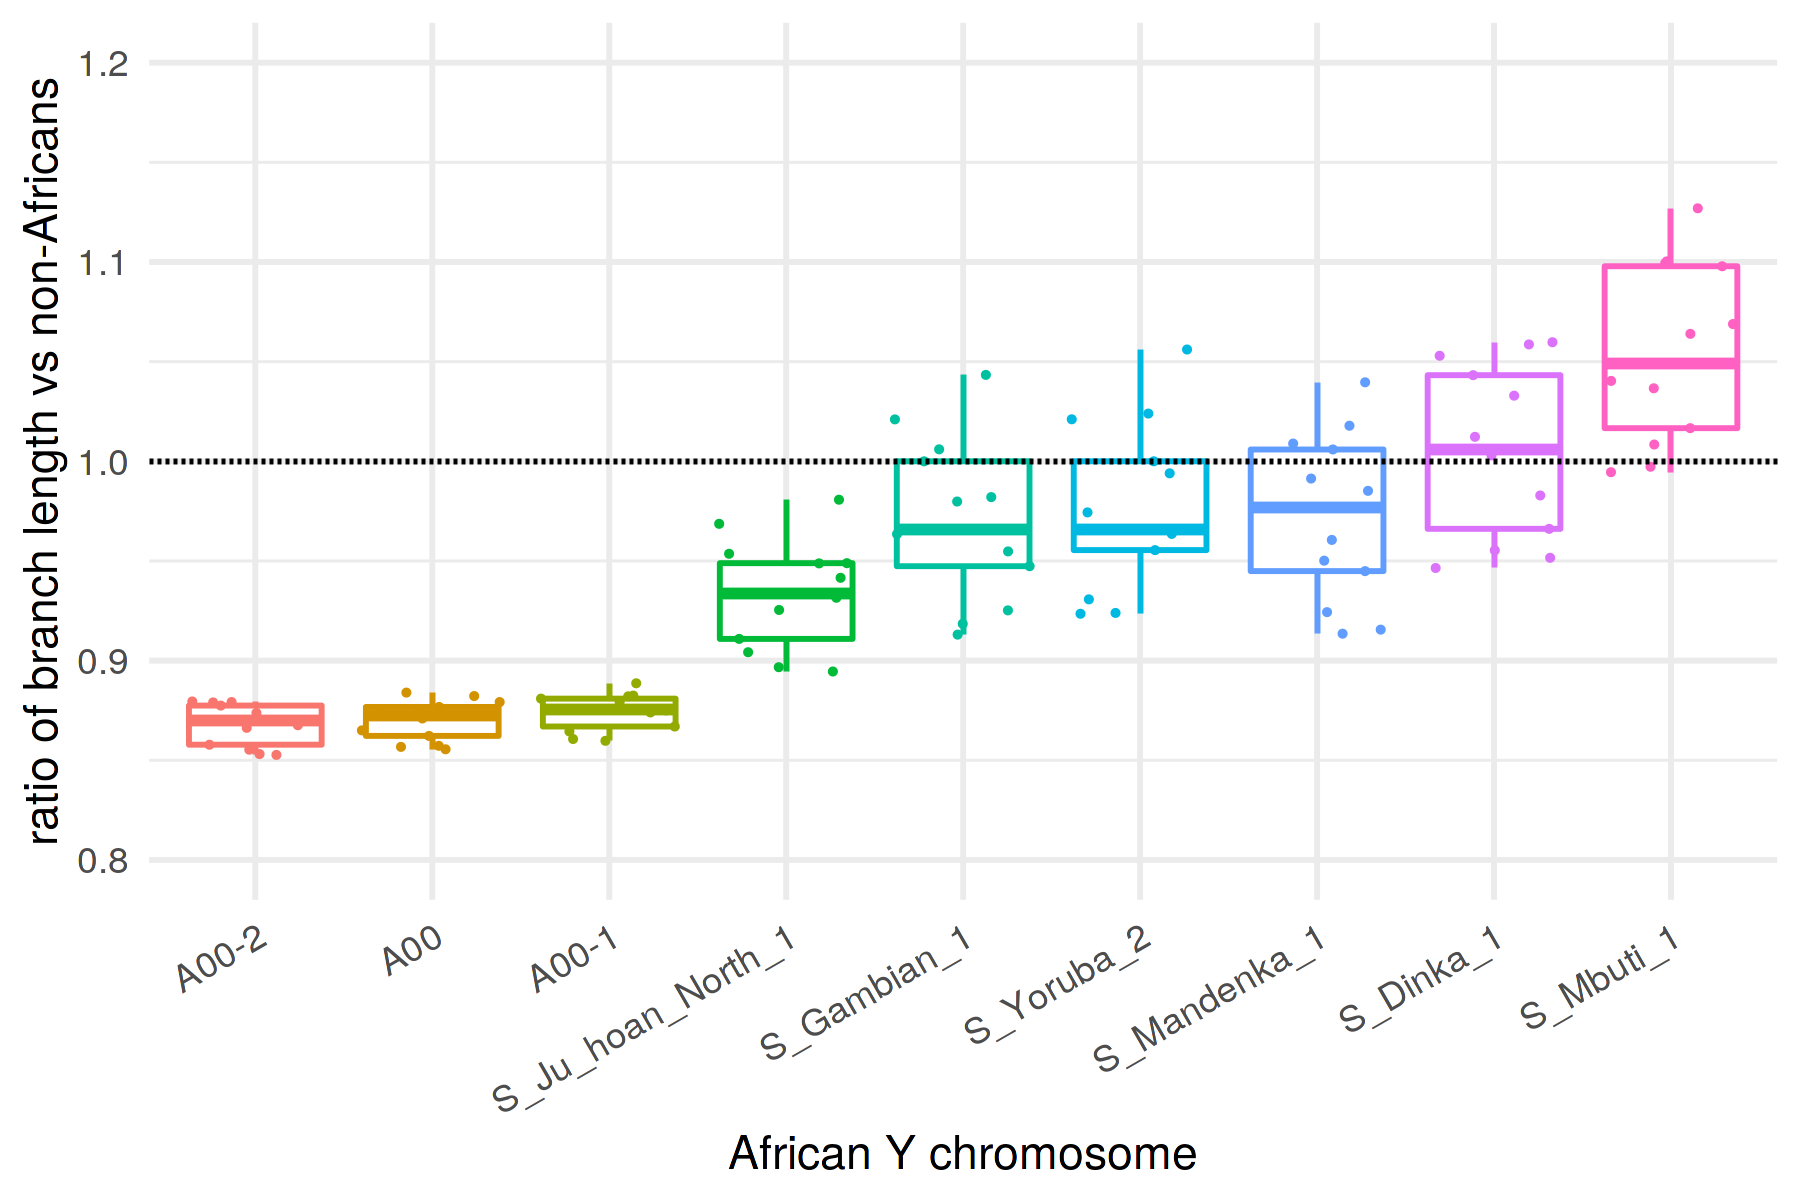

In [5]:
set_dim(6, 4)

branch_lengths %>%
mutate(afr = fix_name(afr)) %>%
ggplot(aes(fct_reorder(afr, ratio), ratio, color = fct_reorder(afr, ratio))) +
    geom_boxplot() +
    geom_jitter(size = 0.25) +
    geom_hline(yintercept = 1, linetype = 2) +
    labs(x = "African Y chromosome", y = "ratio of branch length vs non-Africans") +
    theme_minimal() +
    theme(
        legend.position = "none",
        axis.text.x = element_text(hjust = 1, angle = 30)
    ) +
    coord_cartesian(y = c(0.8, 1.2))

# $\textrm{TMRCA}_{\textrm{archaic}}$ estimates using different African populations

In [6]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

The choice of an African does not matter as long as the coverage in an archaic individual isn't too low. For very low coverage samples, estimates are stable only when the A00 lineage is used (to see this, compare with the high coverage Mez2).

In [7]:
tmrca_long <- tmrca_df %>%
    filter(
        !str_detect(afr, "Mbuti|Dinka"),
        (capture == "full" & !str_detect(arch, "shotgun|snpad|merged")) | (capture == "lippold" & arch == "elsidron2"),
        sites == "all",
        filt == "filt50",
        dp == 3
    ) %>%
    select(arch, afr, tmrca_new, tmrca_mendez) %>%
    gather(statistic, value, -arch, -afr) %>%
    mutate(name = fix_name(arch), afr = fix_name(afr)) %>%
    mutate(statistic = ifelse(statistic == "tmrca_mendez",
                          "TMRCA statistic of Mendez et al.",
                          "New TMRCA statistic"),
       name = str_replace(arch, "mez2_dp(\\d+)", "subsampled to \\1X") %>% fix_name)

## new TMRCA

In [8]:
set_dim(7, 3.5)

p_new_mez2subs <- filter(tmrca_long, str_detect(arch, "mez2"), statistic == "New TMRCA statistic") %>%
mutate(name = fct_relevel(name, "Mezmaiskaya 2", paste0("subsampled to ", 1:10, "X"))) %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2) +
    geom_vline(xintercept = 1.5, size = 0.25, linetype = 5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 500e3)) +
    guides(fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

In [9]:
set_dim(7, 3.5)

p_new_arch <- filter(tmrca_long, !str_detect(arch, "mez2_dp|shotgun|snpad|den$"), statistic == "New TMRCA statistic") %>%
mutate(name = fix_name(arch, coverage = T)) %>%
mutate(name = ifelse(str_detect(name, "560"), "El Sidrón 1253\n(560 kb) (7.9X)", name)) %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2, alpha = 0.5) +
    geom_point(aes(color = fct_reorder(afr, -value)),
               position = position_dodge(width = 0.75), size = 0.5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 1e6)) +
    guides(color = F, fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

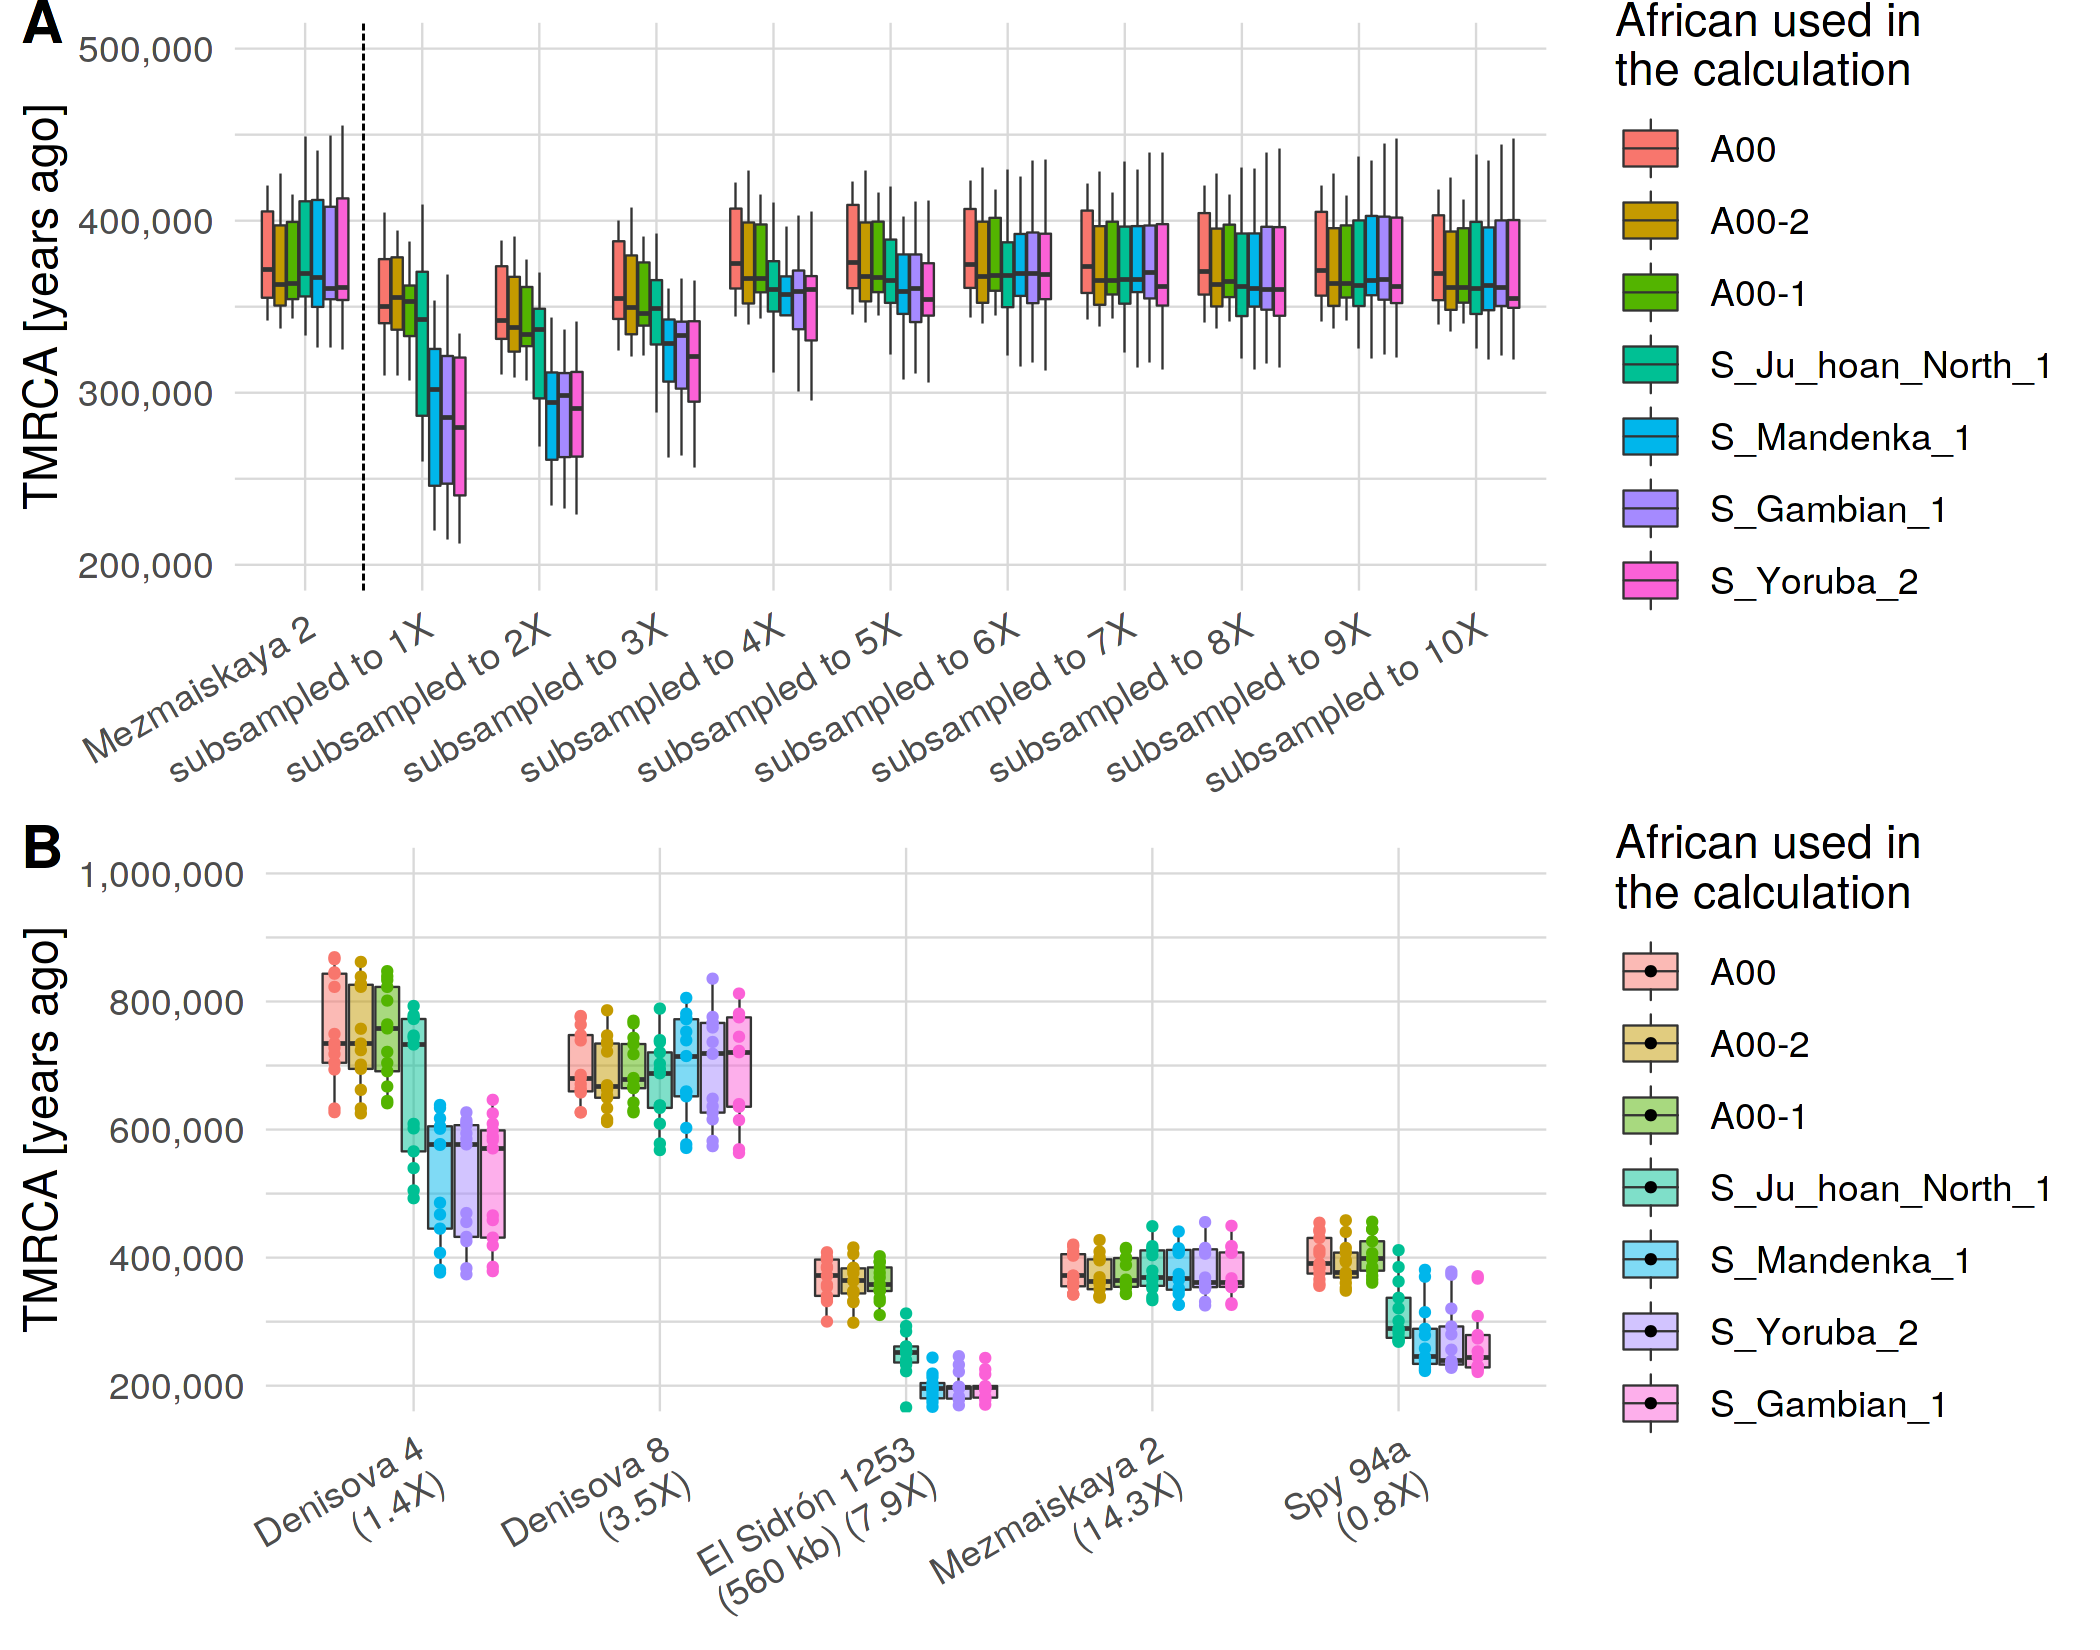

In [10]:
set_dim(7, 5.5)

plot_grid(p_new_mez2subs, p_new_arch, nrow = 2, labels = c("A", "B"), vjust = 1)

## Mendez et al. TMRCA

In [11]:
set_dim(7, 3.5)

p_mendez_mez2subs <- filter(tmrca_long, str_detect(arch, "mez2"), statistic == "TMRCA statistic of Mendez et al.") %>%
mutate(name = fct_relevel(name, "Mezmaiskaya 2", paste0("subsampled to ", 1:10, "X"))) %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2) +
    geom_vline(xintercept = 1.5, size = 0.25, linetype = 5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 500e3)) +
    guides(fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

In [12]:
set_dim(7, 3.5)

p_mendez_arch <- filter(tmrca_long, !str_detect(arch, "mez2_dp|shotgun|snpad|den$"), statistic == "TMRCA statistic of Mendez et al.") %>%
mutate(name = fix_name(arch, coverage = T)) %>%
mutate(name = ifelse(str_detect(name, "560"), "El Sidrón 1253\n(560 kb) (7.9X)", name)) %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2, alpha = 0.5) +
    geom_point(aes(color = fct_reorder(afr, -value)),
               position = position_dodge(width = 0.75), size = 0.5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 1e6)) +
    guides(color = F, fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

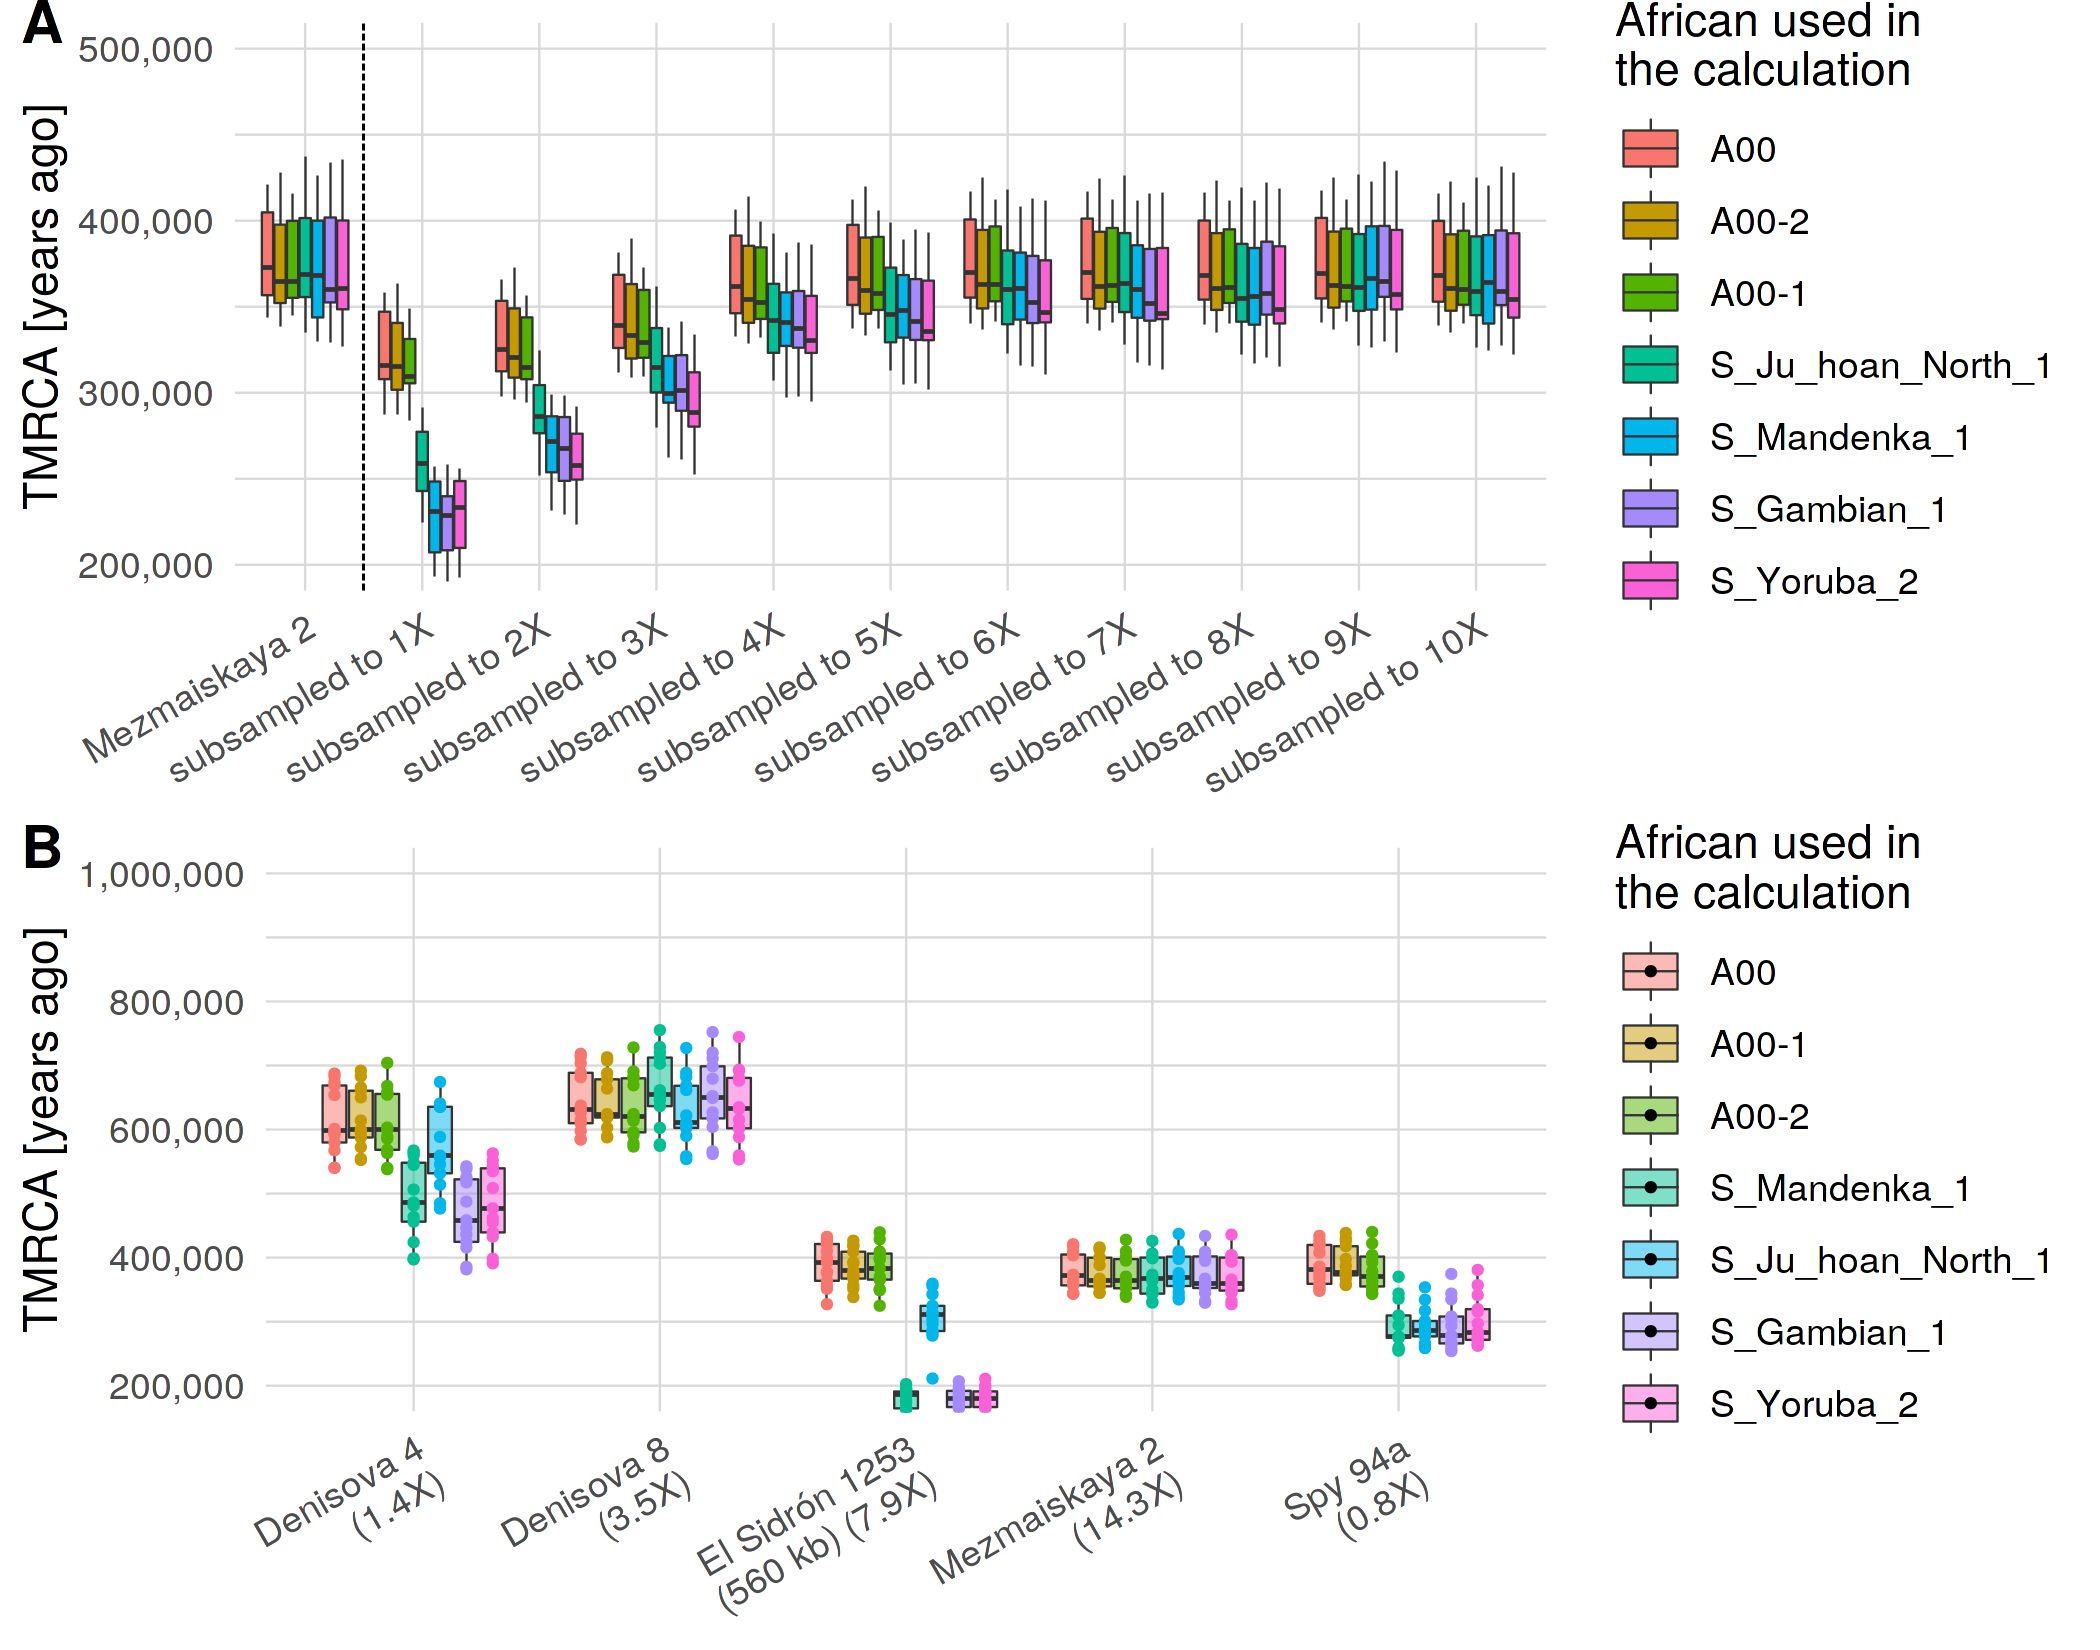

In [13]:
set_dim(7, 5.5)

plot_grid(p_mendez_mez2subs, p_mendez_arch, nrow = 2, labels = c("A", "B"), vjust = 1)